In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import folium
from shapely import wkt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from statsmodels.tsa.stattools import adfuller


import warnings

warnings.filterwarnings('ignore') # Ignore all warnings

In [6]:
df_price = pd.read_csv('Price_waiting_processed.csv')# dataframe for the trip fare prediction

df_demand = pd.read_csv('Demand_forecast.csv')# dataframe for the demand forecast

### PreProcessing

In [7]:
### General analysis

df_price.drop(columns=['airport_fee','tolls','wav_match_flag','wav_request_flag','access_a_ride_flag','tips','congestion_surcharge','shared_match_flag','shared_request_flag'], inplace=True) 
# Explanation: Drops columns with a high percentage of NaN values or non-informative data, such as 'airport_fee' with 99% NaN values, 'tolls' where 90% of the data is 0,
#  'congestion_surcharge' with 60% zeros, 'shared_match_flag' and 'shared_request_flag' with the same value across the dataset, 'tips' with 80% zeros,
#  'access_a_ride_flag' with an undetermined value, 'wav_request_flag' with 90% being 'No', and 'wav_match_flag'
#  on_scene_datetime : nan values for Lyft and Via about 90% of their records (same thing for originating_base_num)

df_price = df_price.dropna(subset=['request_datetime']).reset_index(drop=True) 
# Explanation: Removes records with NaN values in 'request_datetime', resulting in the removal of 4 records.

conditions = [
    (df_price['driver_pay'] > 5) & (df_price['driver_pay'] < 60), # 2% of the records are not adapted, negative values and outliers
    (df_price['trip_miles'] > 0.5) & (df_price['trip_miles'] < 30), # 99% of the records are below 30 miles
    (df_price['trip_time'] > 180) & (df_price['trip_time'] < 3500), # 98% of the records are within the specified range; the remaining 2% are considered outliers
    (df_price['base_passenger_fare'] > 5) & (df_price['base_passenger_fare'] < 70), # 98% of the records fall within this range; the rest are outliers
    (df_price['sales_tax'] < 6) # 99.5% of the records are within this range
]

mask = np.all(conditions, axis=0) # Apply the conditions

df_price = df_price[mask].reset_index(drop=True) # Filter the DataFrame

In [8]:
# Feature extraction for fare-related analysis

# Replace the license numbers with company names
replace_dict = {'HV0003': 'Uber', 'HV0005': 'Lyft', 'HV0004': 'Via'}
df_price['hvfhs_license_num'] = df_price['hvfhs_license_num'].map(replace_dict).fillna(df_price['hvfhs_license_num'])

# Time features extraction:
df_price['request_datetime'] = pd.to_datetime(df_price['request_datetime'])
df_price['pickup_datetime'] = pd.to_datetime(df_price['pickup_datetime'])

df_price['hour_request'] = df_price['request_datetime'].dt.hour
df_price['week_day_request'] = df_price['request_datetime'].dt.dayofweek
df_price['day_category'] = df_price['week_day_request'].apply(lambda x: 'Weekend' if x >= 4 else 'Weekday') # Categorizes days into 'Weekend' or 'Weekday' based on the day of the week.

df_price['waiting_time'] = (df_price['pickup_datetime'] - df_price['request_datetime']).dt.total_seconds() # Feature extraction: Calculate the waiting time in seconds

df_price = df_price[(df_price['waiting_time'] > 90) & (df_price['waiting_time'] < 500)].reset_index(drop=True) # Filter out records where the waiting time is not within the specified range (90 to 500 seconds), which accounts for about 5% of the records.

########

df_price['fare_price'] = df_price['bcf'] + df_price['base_passenger_fare'] + df_price['sales_tax'] # Explanation: 'fare_price' feature that includes all the costs.

df_price['ratio_Price_miles'] = df_price['fare_price'] / df_price['trip_miles'] # Explanation: Creates a new feature 'ratio_Price_miles', representing the fare cost per mile.

df_price = df_price[(df_price['ratio_Price_miles'] < 20) & (df_price['ratio_Price_miles'] > 1)].reset_index(drop=True)
# Explanation: Filters out records with unrealistic 'ratio_Price_miles' values (either too high or too low), likely due to outliers or data entry errors (2%).

# Add a new feature that represents the zone pairs
df_price['PULocationID'] = df_price['PULocationID'].astype(str)
df_price['DOLocationID'] = df_price['DOLocationID'].astype(str)
df_price['Zones_pairs'] = df_price['PULocationID'] + df_price['DOLocationID']


###### to Avoid leakage

train_df, test_df = train_test_split(df_price, test_size=0.25, random_state=42) # Splitting the dataframe into training and test sets


mean_ratio_per_location_end_train = train_df.groupby('DOLocationID')['ratio_Price_miles'].mean() # Calculate the mean ratio of price per mile for each end location in the training set

train_df['ratio_end_location'] = train_df['DOLocationID'].map(mean_ratio_per_location_end_train) # Map the calculated mean ratio from the training set to both the training and test sets
test_df['ratio_end_location'] = test_df['DOLocationID'].map(mean_ratio_per_location_end_train).fillna(0)  # Using 0 or an appropriate value for missing entries

mean_ratio_per_location_start_train = train_df.groupby('PULocationID')['ratio_Price_miles'].mean() # Calculate the mean ratio of price per mile for each start location in the training set

train_df['ratio_Dep_location'] = train_df['PULocationID'].map(mean_ratio_per_location_start_train) # Map the calculated mean ratio from the training set to both the training and test sets
test_df['ratio_Dep_location'] = test_df['PULocationID'].map(mean_ratio_per_location_start_train).fillna(0)  # Using 0 or an appropriate value for missing entries

mean_ratio_per_zonespair_train = train_df.groupby('Zones_pairs')['ratio_Price_miles'].mean() # Calculate the mean ratio of price per mile for each zone pair in the training set

train_df['ratio_zones_pair'] = train_df['Zones_pairs'].map(mean_ratio_per_zonespair_train) # Map the calculated mean ratio from the training set to both the training and test sets
test_df['ratio_zones_pair'] = test_df['Zones_pairs'].map(mean_ratio_per_zonespair_train).fillna(0)  # Using 0 or an appropriate value for missing entries

In [9]:
# Feature extraction for Demand-related analysis

df_demand = df_demand.groupby('date_request_h')['Number_fares'].sum().reset_index()

df_demand['date_request_h'] = pd.to_datetime(df_demand['date_request_h'])
df_demand['day_of_week'] = df_demand['date_request_h'].dt.dayofweek # Extract the day of the week
df_demand['hour'] = df_demand['date_request_h'].dt.hour # Extract the hour
df_demand['day_of_month'] = df_demand['date_request_h'].dt.day # Extract the day of the month
df_demand['month'] = df_demand['date_request_h'].dt.month  # Extracts the month

df_demand = df_demand.set_index('date_request_h') 

target_M = df_demand['Number_fares'].to_dict() 

# Creating lag features to capture temporal dependencies in the data
for i in range(1, 22):
    # For each day from 1 to 21, create a new column 'lagX' where X is the lag day count.
    # This calculates the demand lag .
    df_demand['lag' + str(i)] = (df_demand.index - pd.Timedelta(str(1*i) + ' days')).map(target_M)

# Drop any rows that have NaN values in any of the lag feature columns
df_demand = df_demand.dropna(subset=['lag' + str(i) for i in range(1, 22)])

### Data Visualization

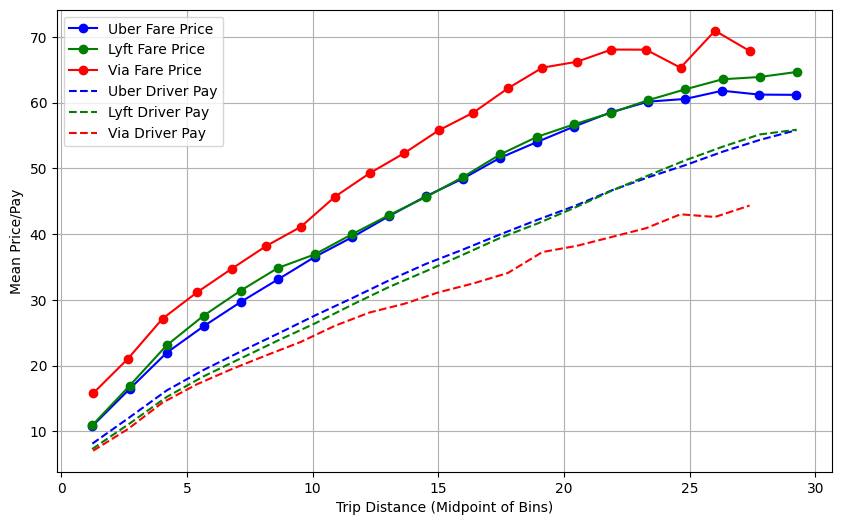

In [10]:
# Filter DataFrames for each service
uber_df = train_df[train_df['hvfhs_license_num'] == 'Uber']
lyft_df = train_df[train_df['hvfhs_license_num'] == 'Lyft']
via_df = train_df[train_df['hvfhs_license_num'] == 'Via']


def mean_price_and_driver_pay_per_bin_adjusted(dataframe, column='trip_miles', 
                                                price_column='fare_price', pay_column='driver_pay', bins=20):
    _, bin_edges = pd.cut(dataframe[column], bins=bins, retbins=True)# Define bins
    dataframe['bin'] = pd.cut(dataframe[column], bins=bin_edges) # Create a new column for bins
    mean_prices = dataframe.groupby('bin')[price_column].mean() # Calculate mean price per bin
    mean_pay = dataframe.groupby('bin')[pay_column].mean()  # Calculate mean driver pay per bin
    
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate midpoints of bins using the bin edges
    
    return bin_mids, mean_prices.values, mean_pay.values

# Recalculate mean prices and driver pay per bin using the adjusted function for each company
uber_bin_mids, uber_means, uber_driver_pay = mean_price_and_driver_pay_per_bin_adjusted(uber_df, 'trip_miles', 'fare_price', 'driver_pay')
lyft_bin_mids, lyft_means, lyft_driver_pay = mean_price_and_driver_pay_per_bin_adjusted(lyft_df, 'trip_miles', 'fare_price', 'driver_pay')
via_bin_mids, via_means, via_driver_pay = mean_price_and_driver_pay_per_bin_adjusted(via_df, 'trip_miles', 'fare_price', 'driver_pay')

plt.figure(figsize=(10, 6))

# Plot fare price data
plt.plot(uber_bin_mids, uber_means, label='Uber Fare Price', marker='o', color='blue')
plt.plot(lyft_bin_mids, lyft_means, label='Lyft Fare Price', marker='o', color='green')
plt.plot(via_bin_mids, via_means, label='Via Fare Price', marker='o', color='red')

# Plot driver pay data
plt.plot(uber_bin_mids, uber_driver_pay, label='Uber Driver Pay', linestyle='--', color='blue')
plt.plot(lyft_bin_mids, lyft_driver_pay, label='Lyft Driver Pay', linestyle='--', color='green')
plt.plot(via_bin_mids, via_driver_pay, label='Via Driver Pay', linestyle='--', color='red')

plt.xlabel('Trip Distance (Midpoint of Bins)')
plt.ylabel('Mean Price/Pay')
#plt.title('Mean Fare Price and Driver Pay per Trip Distance Bin by Company')
plt.legend()
plt.grid(True)
plt.show()


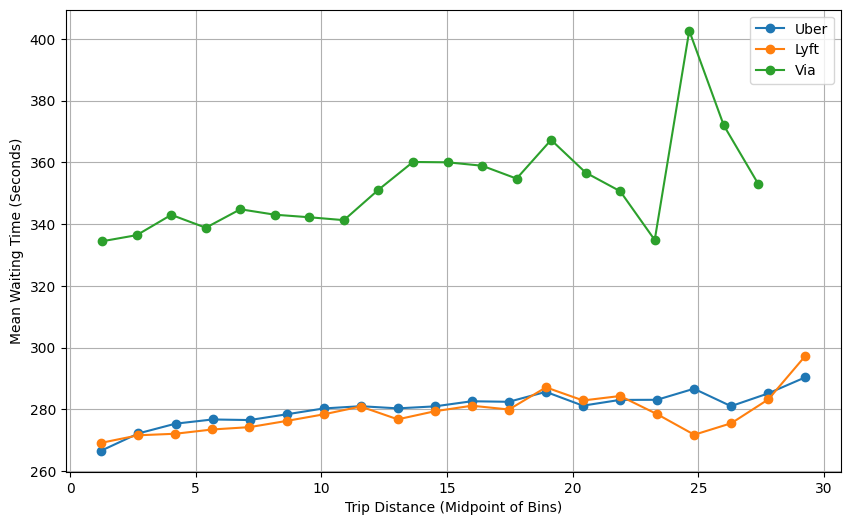

In [11]:
def mean_waiting_time_per_bin(dataframe, column='trip_miles', waiting_time_column='waiting_time', bins=20):
    _, bin_edges = pd.cut(dataframe[column], bins=bins, retbins=True)
    
    dataframe['bin'] = pd.cut(dataframe[column], bins=bin_edges)
    mean_waiting_times = dataframe.groupby('bin')[waiting_time_column].mean()
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    return bin_mids, mean_waiting_times.values


# Recalculate mean waiting times per bin for each company
uber_bin_mids, uber_means = mean_waiting_time_per_bin(uber_df, 'trip_miles', 'waiting_time')
lyft_bin_mids, lyft_means = mean_waiting_time_per_bin(lyft_df, 'trip_miles', 'waiting_time')
via_bin_mids, via_means = mean_waiting_time_per_bin(via_df, 'trip_miles', 'waiting_time')

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(uber_bin_mids, uber_means, label='Uber', marker='o')
plt.plot(lyft_bin_mids, lyft_means, label='Lyft', marker='o')
plt.plot(via_bin_mids, via_means, label='Via', marker='o')

plt.xlabel('Trip Distance (Midpoint of Bins)')
plt.ylabel('Mean Waiting Time (Seconds)')
#plt.title('Mean Waiting Time per Trip Distance Bin by Company')
plt.legend()
plt.grid(True)
plt.show()

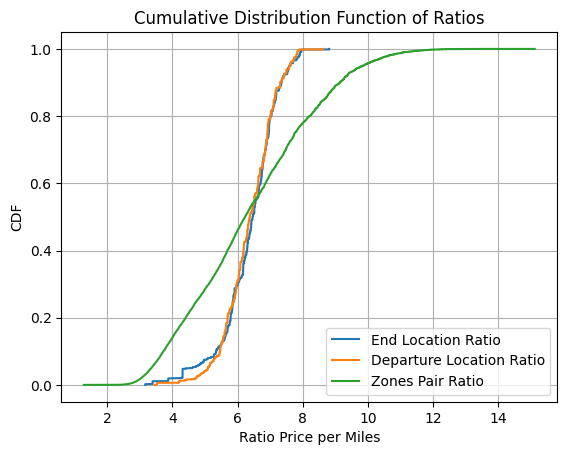

In [12]:
def plot_cdf(data, label):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    # Plotting the CDF
    plt.plot(x, y, label=label)

# Plotting CDF for both 'ratio_end_location' and 'ratio_Dep_location'
plot_cdf(train_df['ratio_end_location'], 'End Location Ratio')
plot_cdf(train_df['ratio_Dep_location'], 'Departure Location Ratio')
plot_cdf(train_df['ratio_zones_pair'], 'Zones Pair Ratio')

plt.xlabel('Ratio Price per Miles')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function of Ratios')
plt.legend()
plt.grid(True)
plt.show()


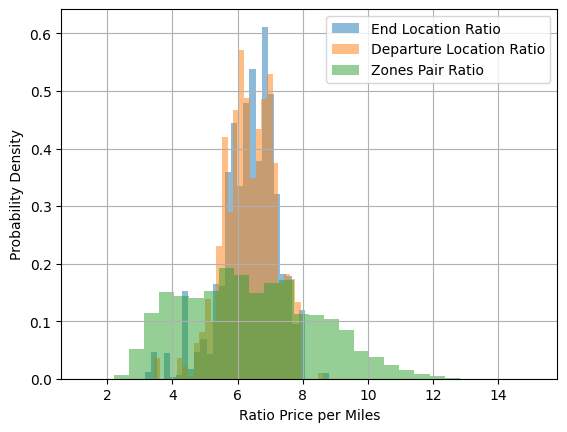

In [13]:
def plot_pdf(data, label, bins=30, density=True, alpha=0.5):
    # Plotting the PDF using a histogram
    plt.hist(data, bins=bins, density=density, alpha=alpha, label=label)


# Plotting PDF for 'ratio_end_location', 'ratio_Dep_location', and 'ratio_zones_pair'
plot_pdf(train_df['ratio_end_location'], 'End Location Ratio')
plot_pdf(train_df['ratio_Dep_location'], 'Departure Location Ratio')
plot_pdf(train_df['ratio_zones_pair'], 'Zones Pair Ratio')

plt.xlabel('Ratio Price per Miles')
plt.ylabel('Probability Density')
#plt.title('Probability Density Function of Ratios')
plt.legend()
plt.grid(True)
plt.show()


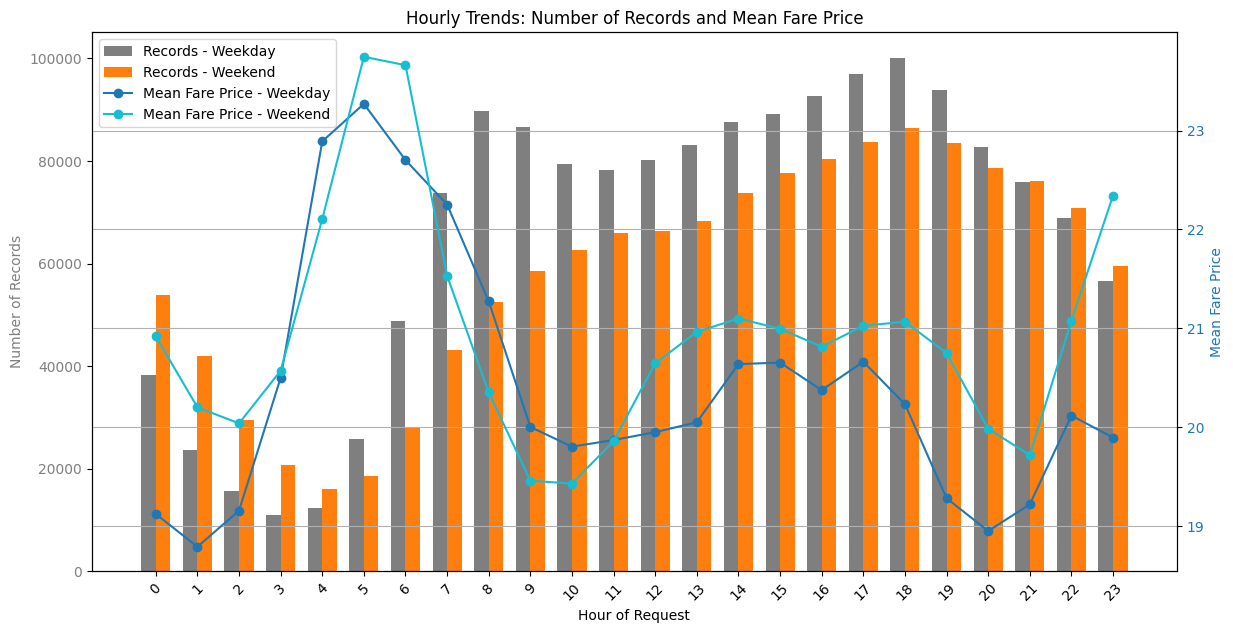

In [14]:
hourly_records = train_df.groupby(['hour_request', 'day_category']).size().unstack(fill_value=0)

mean_price_per_hour = train_df.groupby(['hour_request', 'day_category'])['fare_price'].mean().unstack(fill_value=0) # Calculate mean fare_price per hour for each day category


fig, ax1 = plt.subplots(figsize=(14, 7))

hours = mean_price_per_hour.index.values  
width = 0.35  

# Bar plot for the number of records
ax1.bar(hours - width/2, hourly_records['Weekday'].values, width, label='Records - Weekday', color='tab:gray')
ax1.bar(hours + width/2, hourly_records['Weekend'].values, width, label='Records - Weekend', color='tab:orange')

ax1.set_xlabel('Hour of Request')
ax1.set_ylabel('Number of Records', color='tab:gray')
ax1.tick_params(axis='y', labelcolor='tab:gray')
ax1.set_xticks(hours)
ax1.set_xticklabels(hours.astype(str), rotation=45)  

# Create a twin Axes sharing the x-axis for mean fare price line plots
ax2 = ax1.twinx()
ax2.plot(hours, mean_price_per_hour['Weekday'].values, label='Mean Fare Price - Weekday', color='tab:blue', marker='o', linestyle='-')
ax2.plot(hours, mean_price_per_hour['Weekend'].values, label='Mean Fare Price - Weekend', color='tab:cyan', marker='o', linestyle='-')

ax2.set_ylabel('Mean Fare Price', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Hourly Trends: Number of Records and Mean Fare Price')
plt.grid(True)
plt.show()

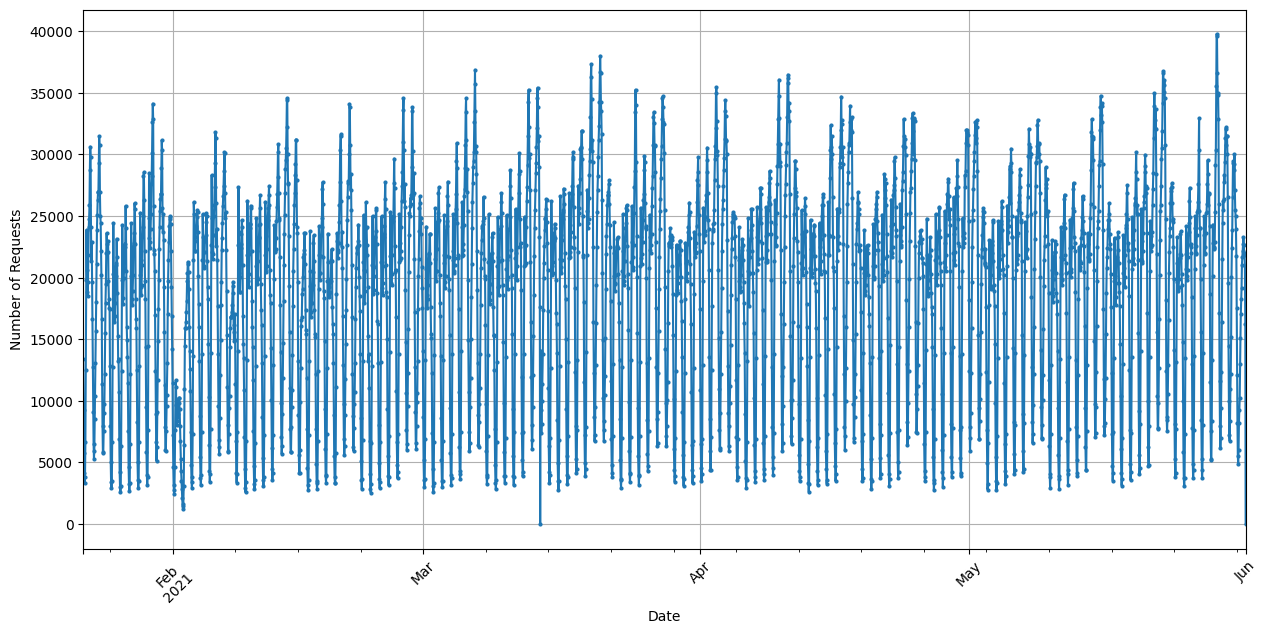

In [15]:
if 'date_request_h' in df_demand.columns: # Check if 'date_request_h' is the index, if not, set it as the index
    df_demand.set_index('date_request_h', inplace=True)

df_demand.index = pd.to_datetime(df_demand.index) # Ensure the index is in datetime format

df_demand['Number_fares'].plot(figsize=(15, 7), marker='o', linestyle='-', markersize=2)
plt.xlabel('Date')
plt.ylabel('Number of Requests')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [16]:
result = adfuller(df_demand['Number_fares']) # Perform Augmented Dickey-Fuller test
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if result[1] > 0.05:
    print("Series is non-stationary")
else:
    print("Series is stationary")


ADF Statistic: -5.526858
p-value: 0.000002
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Series is stationary


### Models

In [17]:
# Perform one-hot encoding for 'hvfhs_license_num'
X_train = pd.get_dummies(train_df[['trip_miles','hour_request','month','week_day_request','hvfhs_license_num','ratio_zones_pair','ratio_Dep_location','ratio_end_location']])
y_train = train_df['fare_price']

# Split the data into training and testing sets (75% train, 25% test)
X_test = pd.get_dummies(test_df[['trip_miles','hour_request','month','week_day_request','hvfhs_license_num','ratio_zones_pair','ratio_Dep_location','ratio_end_location']])
y_test = test_df['fare_price']


max_depth = 15  # Specify the depth directly

model = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

Mean Squared Error: 27.492745071506995
R^2 Score: 0.8127909046470199


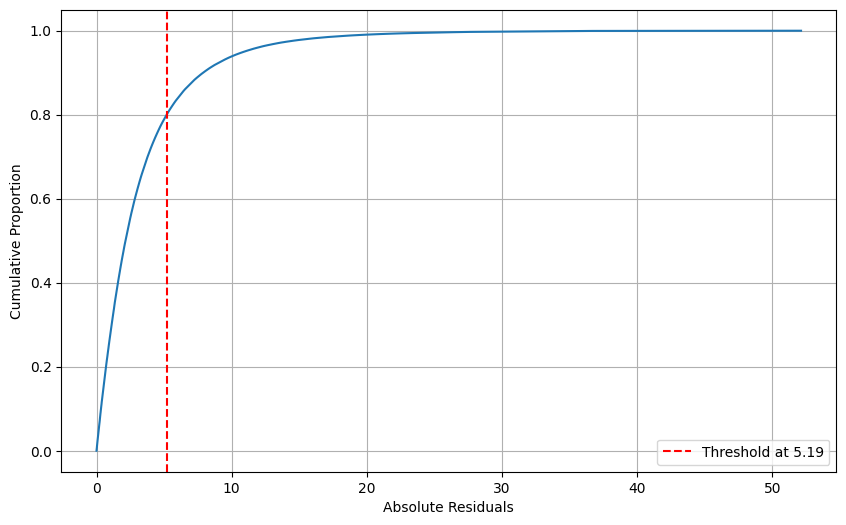

In [18]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
absolute_residuals = np.abs(residuals)
sorted_abs_residuals = np.sort(absolute_residuals)
cumulative_proportion = np.linspace(0, 1, len(sorted_abs_residuals), endpoint=False)
plt.plot(sorted_abs_residuals, cumulative_proportion)
plt.xlabel('Absolute Residuals')
plt.ylabel('Cumulative Proportion')
#plt.title('CDF of Absolute Residuals')
plt.grid(True)

idx = np.where(cumulative_proportion > 0.8)[0][0]# Find the index where the cumulative proportion surpasses 0.8

plt.axvline(x=sorted_abs_residuals[idx], color='r', linestyle='--', label=f'Threshold at {sorted_abs_residuals[idx]:.2f}')# Add a vertical line at x-value when cumulative proportion surpasses 0.8

plt.legend()

plt.show()


The figure demonstrates that approximately 80\% of the predictions have an error margin between -5.19 and 5.19, highlighting the model's precision in estimating fare prices.

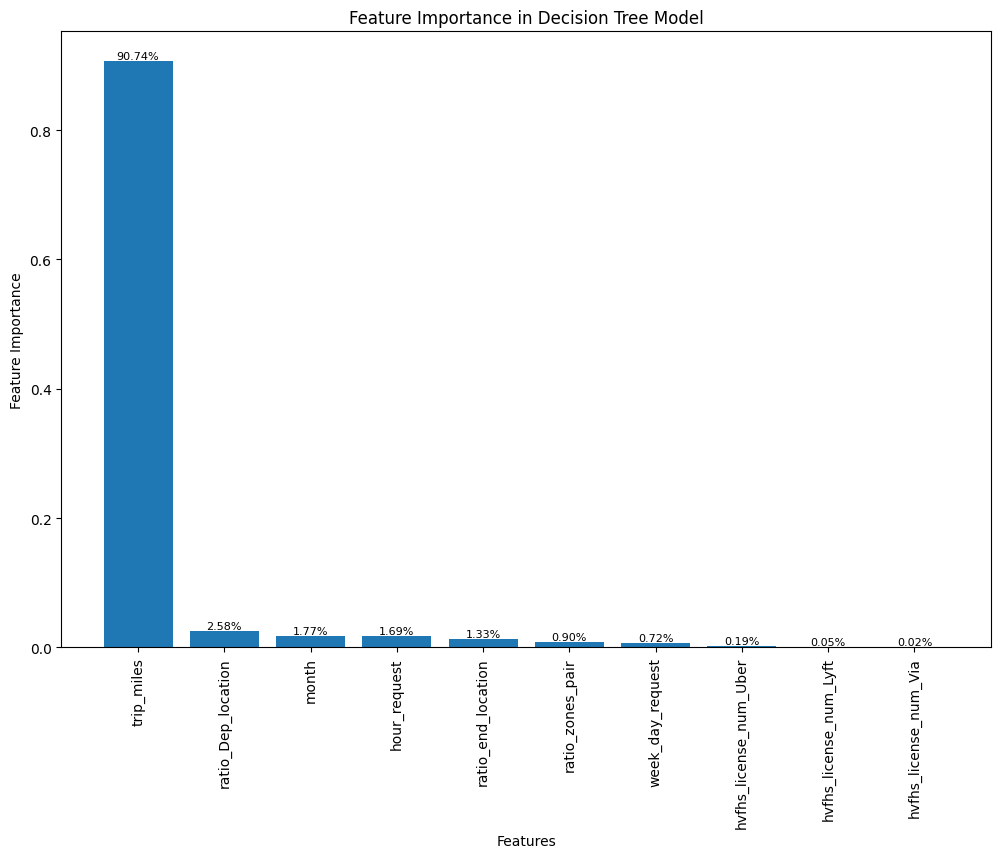

In [19]:
feature_importance = model.feature_importances_

sorted_idx = np.argsort(feature_importance)[::-1]

labels = [X_train.columns[i] for i in sorted_idx]

plt.figure(figsize=(12, 8))
bars = plt.bar(range(X_train.shape[1]), feature_importance[sorted_idx], align='center')
plt.xticks(range(X_train.shape[1]), labels, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importance in Decision Tree Model')

# Add percentages inside the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, '{:.2f}%'.format(height * 100),
             ha='center', va='bottom', fontsize=8)

plt.show()


[0]	validation_0-rmse:20606.45653	validation_1-rmse:21357.30939
[100]	validation_0-rmse:18668.83148	validation_1-rmse:19374.67065
[200]	validation_0-rmse:16916.25746	validation_1-rmse:17572.70925
[300]	validation_0-rmse:15330.81536	validation_1-rmse:15950.97945
[400]	validation_0-rmse:13896.74476	validation_1-rmse:14484.70943
[500]	validation_0-rmse:12599.73471	validation_1-rmse:13159.55767
[600]	validation_0-rmse:11426.90974	validation_1-rmse:11959.32556
[700]	validation_0-rmse:10366.51776	validation_1-rmse:10876.94831
[800]	validation_0-rmse:9407.92011	validation_1-rmse:9901.22257
[900]	validation_0-rmse:8542.08484	validation_1-rmse:9026.42338
[1000]	validation_0-rmse:7760.22457	validation_1-rmse:8239.46455
[1100]	validation_0-rmse:7054.33995	validation_1-rmse:7531.42282
[1200]	validation_0-rmse:6417.38113	validation_1-rmse:6896.23003
[1300]	validation_0-rmse:5842.67724	validation_1-rmse:6324.69541
[1400]	validation_0-rmse:5324.14716	validation_1-rmse:5815.15181
[1500]	validation_0-r

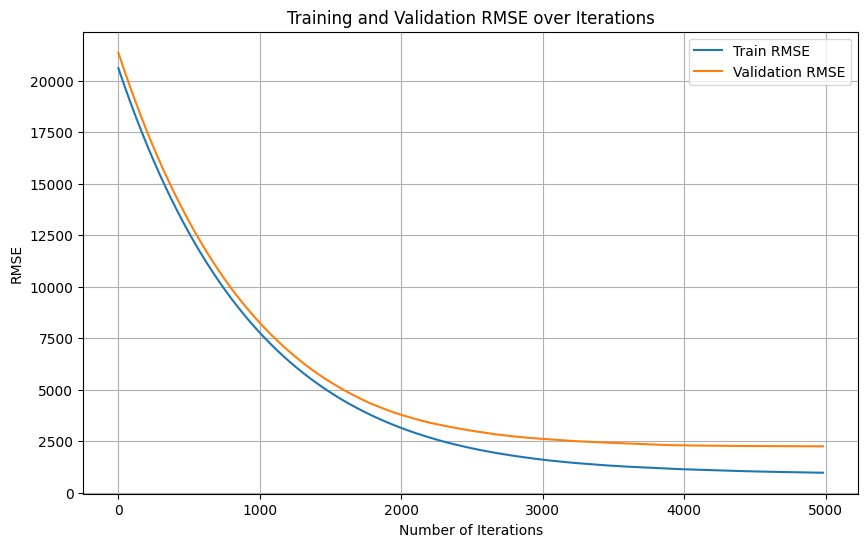

Mean Squared Error: 5059667.05665521


In [20]:
train = df_demand.loc[df_demand.index < '2021-05-24 00:00:00']
test = df_demand.loc[df_demand.index >= '2021-05-24 00:00:00']

Features = ['day_of_week','day_of_month','hour','lag7','lag14','lag21','month']
Target = 'Number_fares'

X_train = train[Features]
y_train = train[Target]

X_test = test[Features]
y_test = test[Target]

reg = xgb.XGBRegressor(n_estimators=10000, 
                       learning_rate=0.001,
                       random_state=42)

reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        early_stopping_rounds=50, 
        verbose=100)

results = reg.evals_result()

train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']
iterations = range(1, len(train_rmse) + 1)

plt.figure(figsize=(10, 6))
plt.plot(iterations, train_rmse, label='Train RMSE')
plt.plot(iterations, val_rmse, label='Validation RMSE')
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE over Iterations')
plt.legend()
plt.grid(True)
plt.show()

# Predictions and evaluation
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")


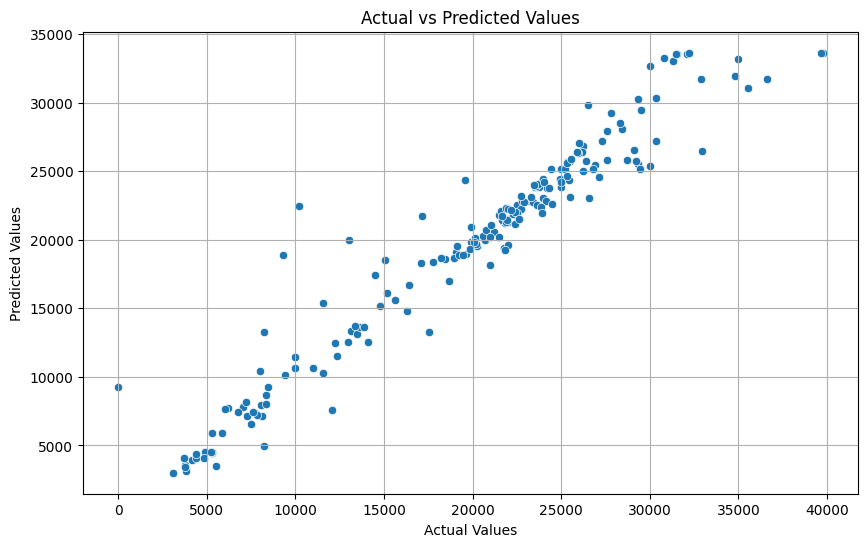

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.show()


The figure illustrates that the predicted values closely align with the actual data.

##### Zones classification

In [22]:
df_price['waiting_time'] = (pd.to_datetime(df_price['pickup_datetime']) - pd.to_datetime(df_price['request_datetime'])).dt.total_seconds() / 60.0  # in minutes

pickup_stats = df_price.groupby('PULocationID').agg(
    num_trips_per_PULocationID=('PULocationID', 'size'),
    mean_waiting_time_per_PULocationID=('waiting_time', 'mean'),
    mean_ratio_Price_miles_per_PULocationID=('ratio_Price_miles', 'mean')
).reset_index()

dropoff_stats = df_price.groupby('DOLocationID').agg(
    num_trips_per_DOLocationID=('DOLocationID', 'size')
).reset_index()

pickup_stats.rename(columns={'PULocationID': 'LocationID'}, inplace=True)
dropoff_stats.rename(columns={'DOLocationID': 'LocationID'}, inplace=True)

location_stats = pd.merge(pickup_stats, dropoff_stats, on='LocationID', how='outer')

location_stats['num_trips_per_PULocationID'].fillna(0, inplace=True)
location_stats['num_trips_per_DOLocationID'].fillna(0, inplace=True)

location_stats = location_stats.dropna().reset_index(drop=True)
location_stats['LocationID'] = location_stats['LocationID'].astype(int)
location_stats.head()

,LocationID,num_trips_per_PULocationID,mean_waiting_time_per_PULocationID,mean_ratio_Price_miles_per_PULocationID,num_trips_per_DOLocationID
0,1,16.0,5.992708,3.279663,9281
1,10,16450.0,4.413687,5.089322,13201
2,100,14933.0,4.299503,7.012497,16148
3,101,2714.0,4.707971,4.424683,2209
4,102,10470.0,4.679398,5.834159,10398


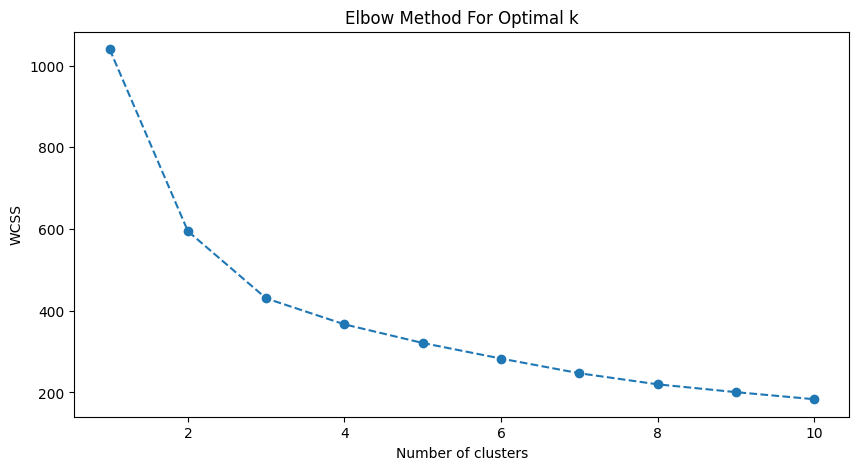

In [23]:
imputer = SimpleImputer(strategy='mean')
location_stats_filled = imputer.fit_transform(location_stats[['num_trips_per_PULocationID', 'num_trips_per_DOLocationID', 'mean_waiting_time_per_PULocationID', 'mean_ratio_Price_miles_per_PULocationID']])

scaler = StandardScaler()
location_stats_scaled = scaler.fit_transform(location_stats_filled)

# Choosing the Number of Clusters (K) - Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(location_stats_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the results onto a line graph to observe the 'elbow'
plt.figure(figsize=(10,5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()



In [24]:
# Applying K-Means Clustering

n_clusters = 4  # Example based on visual inspection of the elbow plot
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(location_stats_scaled)

location_stats['Cluster'] = cluster_labels

location_stats.head()

,LocationID,num_trips_per_PULocationID,mean_waiting_time_per_PULocationID,mean_ratio_Price_miles_per_PULocationID,num_trips_per_DOLocationID,Cluster
0,1,16.0,5.992708,3.279663,9281,1
1,10,16450.0,4.413687,5.089322,13201,0
2,100,14933.0,4.299503,7.012497,16148,3
3,101,2714.0,4.707971,4.424683,2209,1
4,102,10470.0,4.679398,5.834159,10398,0


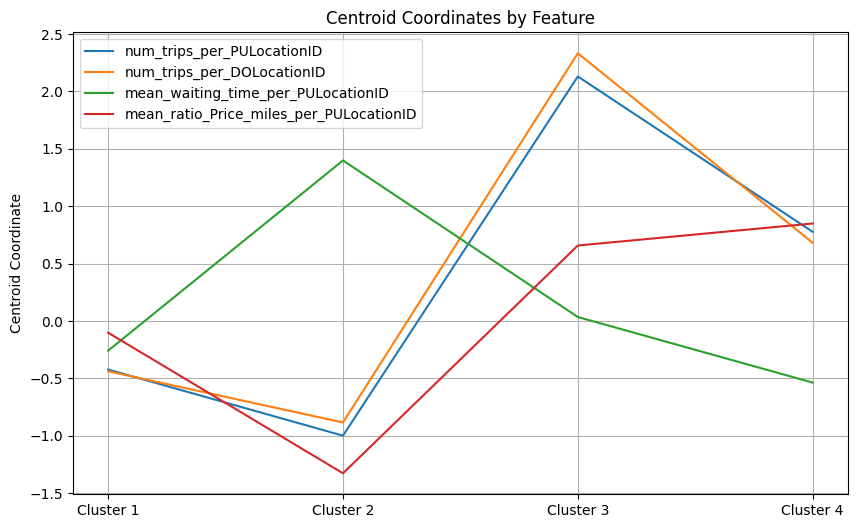

In [25]:
centroids = kmeans.cluster_centers_

feature_names = ['num_trips_per_PULocationID', 'num_trips_per_DOLocationID', 'mean_waiting_time_per_PULocationID', 'mean_ratio_Price_miles_per_PULocationID']
centroids_df = pd.DataFrame(centroids, columns=feature_names)

plt.figure(figsize=(10, 6))
for feature in feature_names:
    plt.plot(centroids_df[feature], label=feature)

plt.xticks(ticks=np.arange(n_clusters), labels=[f'Cluster {i}' for i in range(1,n_clusters+1)])
plt.ylabel('Centroid Coordinate')
plt.title('Centroid Coordinates by Feature')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
zones = pd.read_csv('nyc-taxi-zones-1.csv')

merged_df = pd.merge(zones, location_stats, on='LocationID', how='inner')
merged_df.head()

,OBJECTID,Shape_Leng,the_geom,Shape_Area,zone,LocationID,borough,num_trips_per_PULocationID,mean_waiting_time_per_PULocationID,mean_ratio_Price_miles_per_PULocationID,num_trips_per_DOLocationID,Cluster
0,1,0.116357,MULTIPOLYGON (((-74.18445299999996 40.69499599...,0.000782,Newark Airport,1,EWR,16.0,5.992708,3.279663,9281,1
1,2,0.433470,MULTIPOLYGON (((-73.82337597260663 40.63898704...,0.004866,Jamaica Bay,2,Queens,7.0,6.347619,3.905835,8,1
2,3,0.084341,MULTIPOLYGON (((-73.84792614099985 40.87134223...,0.000314,Allerton/Pelham Gardens,3,Bronx,10672.0,4.669283,5.594184,9660,0
3,4,0.043567,MULTIPOLYGON (((-73.97177410965318 40.72582128...,0.000112,Alphabet City,4,Manhattan,14203.0,4.700541,6.617406,12251,0
4,5,0.092146,MULTIPOLYGON (((-74.17421738099989 40.56256808...,0.000498,Arden Heights,5,Staten Island,686.0,5.594023,4.514392,649,1


Cluster 1: Represents areas with slightly lower demand, shorter waiting times, and lower prices per mile (represented in green on the map below).

Cluster 2: Corresponds to areas with cheaper fares and lower demand for taxi services (represented in blue on the map below).

Cluster 3: Indicates areas with high transportation demand, suggesting busy routes and potentially higher fares (represented in red on the map below).

Cluster 4: Represents areas with slightly higher demand and price per mile, along with shorter waiting times. Likely experiencing moderate transportation demand with slightly higher fares.

In [27]:
location_stats['Cluster'] = location_stats['Cluster'].astype(int)
merged_df = pd.merge(zones, location_stats, how='inner', on='LocationID')

# Define a distinct color map for clusters
cluster_colors = {
    0: 'green',
    1: 'blue',
    2: 'red',
    3: 'orange',
}

# Map colors in the DataFrame
merged_df['Color'] = merged_df['Cluster'].map(cluster_colors).fillna('gray')

# Center of the map - New York's geographic center approximation
map_center = [40.7128, -74.0060]
folium_map = folium.Map(location=map_center, zoom_start=10)

for _, row in merged_df.iterrows():
    polygon = wkt.loads(row['the_geom'])
    simple_polygon = polygon.simplify(tolerance=0.001, preserve_topology=True)
    tooltip_text = f"Borough: {row['borough']} <br> Zone name: {row['zone']}"
    
    geojson = folium.GeoJson(
        data=simple_polygon,
        style_function=lambda x, color=row['Color']: {
            'fillColor': color, 
            'color': color, 
            'weight': 1, 
            'fillOpacity': 0.3
        },
        tooltip=tooltip_text
    )
    
    geojson.add_to(folium_map)


folium_map